For a while I've been thinking about Yelp reviews, in particular about the information lost by distilling the reviews down to one number. It isn't clear how this number, the average rating, is calculated either. Is it an average over all time? Is it only considering the last month? Or, is it weighted such that more recent reviews have a larger effect on the average?

A lot of the information lost is in the time domain, the change in time of a business' ratings. Presumably, a change in ownership or management could result in a change in the quality of a business, positively or negatively. Also, a business that just opened might get poor reviews but over time improves through addressing feedback or from the staff gaining more experience. These sort of changes should be present in user reviews on Yelp. I'd like to find a way to see these changes to get a better sense of the quality of a business.

First, we'll need to grab a bunch of reviews from Yelp. Yelp provides an [API for searching](https://www.yelp.com/developers/documentation/v2/search_api) and an API for [requesting business data](https://www.yelp.com/developers/documentation/v2/business). An API is an Application Programming Interface, basically a list of instructions for interfacting with Yelp's data. The way these work is similar to viewing a web page. When you point your browser to a website, you do it with a URL (http://www.yelp.com for instance). Yelp sends you back data containing HTML, CSS, and Javascript. Your browser uses this data to construct the page that you see. The API works similarly, you request data with a URL (http://api.yelp.com/stuff), but instead of getting HTML and such, you get data  formatted  as [JSON](http://en.wikipedia.org/wiki/JSON).

Using the APIs, we can search like you would on the website, but through Python code. We can also request data about businesses we find from searching. I'll get started by creating a function to perform API requests.

<!-- fold -->

In [1]:
import json
import urllib2

import oauth2

Using Yelp's API requires secret keys to sign a URL request. Yelp gives you these keys, if you want to try this code, you'll need to get your own. Following Yelp's [sample code](https://github.com/Yelp/yelp-api/tree/master/v2/python), I've written a function to make an API request with OAuth2. To use the APIs, you need to get secret keys from Yelp.

In [3]:
# Use your own keys here
TOKEN = None
TOKEN_SECRET = None
CONSUMER = None
CONSUMER_SECRET = None

In [8]:
# This function performs a Yelp API request, taken from Yelp's python example
def api_request(url, url_params):
    """ Make a request with Yelp's API """
    consumer = oauth2.Consumer(CONSUMER, CONSUMER_SECRET)
    token = oauth2.Token(TOKEN, TOKEN_SECRET)

    oauth_request = oauth2.Request(method="GET", url=url, parameters=url_params)
    oauth_request.update({'oauth_nonce': oauth2.generate_nonce(),
                          'oauth_timestamp': oauth2.generate_timestamp(),
                          'oauth_token': TOKEN,
                          'oauth_consumer_key': CONSUMER})

    oauth_request.sign_request(oauth2.SignatureMethod_HMAC_SHA1(), consumer, token)
    signed_url = oauth_request.to_url()
    
    conn = urllib2.urlopen(signed_url, None)
    try:
        response = json.loads(conn.read())
    finally:
        conn.close()
        
    return response

Now that I can make requests, I'll write a function that will search Yelp for businesses based on a search term and a location.

In [9]:
def search(term, location, limit=5):
    """ Search Yelp with a term and location """
    url = 'http://api.yelp.com/v2/search'
    url_params = {'term': term.replace(' ', '+'),
                  'location': location.replace(' ', '+'),
                  'limit': limit}
    response = api_request(url, url_params)
    bizs = response['businesses']
    return bizs

Let's look for sushi in San Francisco's Mission neighborhood because sometimes you've already had three burritos this week.

In [10]:
from pprint import pprint
bizs = search('sushi', 'Mission, San Francisco, CA')
# Look at our results and the ratings
pprint([(biz['name'], biz['rating']) for biz in bizs])

[(u'Kazan', 4.5),
 (u'Sugoi Sushi', 4.0),
 (u'Saru Sushi Bar', 4.5),
 (u'Live Sushi Bar', 4.0),
 (u'Pink Zebra', 4.5)]


Now that we can search Yelp for businesses, let's see what sort of data we can get. Below is a short function for requesting data from Yelp's business API.

In [11]:
def get_business(biz_id):
    """ Get business data from Yelp """
    url = 'http://api.yelp.com/v2/business/{}'.format(biz_id)
    response = api_request(url, None)
    return response

In [12]:
biz = get_business(bizs[0]['id'])
pprint(biz)

{u'categories': [[u'Japanese', u'japanese'], [u'Sushi Bars', u'sushi']],
 u'display_phone': u'+1-415-282-2001',
 u'id': u'kazan-san-francisco',
 u'image_url': u'http://s3-media3.fl.yelpcdn.com/bphoto/bnY1-1e0XdPz6zTrG5dacA/ms.jpg',
 u'is_claimed': False,
 u'is_closed': False,
 u'location': {u'address': [u'2809 24th St'],
               u'city': u'San Francisco',
               u'coordinate': {u'latitude': 37.75264,
                               u'longitude': -122.408447},
               u'country_code': u'US',
               u'cross_streets': u'York St & Bryant St',
               u'display_address': [u'2809 24th St',
                                    u'Mission',
                                    u'San Francisco, CA 94110'],
               u'geo_accuracy': 8.0,
               u'neighborhoods': [u'Mission'],
               u'postal_code': u'94110',
               u'state_code': u'CA'},
 u'mobile_url': u'http://m.yelp.com/biz/kazan-san-francisco',
 u'name': u'Kazan',
 u'phone': u'41

## Web scraping Yelp 

Looking through the business data, we can see that we get only one review from the API request. However, I want a bunch of reviews to analyze, so we'll have to find some other way to get user ratings. The solution is to extract the ratings data from Yelp's website (called [scraping](http://en.wikipedia.org/wiki/Web_scraping)). To do this, I'm going to use a couple great packages. First, I'll use [requests](http://docs.python-requests.org/en/latest/) to retrieve the webpage's HTML data. Then I can use [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/) to search through the HTML to find user ratings and dates. Below, I'll create a function to search Yelp and get the ratings data.

In [13]:
%matplotlib inline

from datetime import date, timedelta as td

import bs4 # BeautifulSoup 4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_context('talk')

In [24]:
sb.set_contextext('notebook')

In [14]:
def scrape_data(biz):
    """ Accepts a business entry from Yelp's API, scrapes rating data from the business' Yelp page """
    stars, dates = [], []
    n_reviews = biz['review_count']
    # There are 40 reviews per page
    n_pages = n_reviews/40 + 1
    for page_start in range(0, n_pages*40, 40):
        url = 'http://www.yelp.com/biz/{}?start={}&sort_by=date_desc'.format(biz['id'], page_start) 
        response = urllib2.urlopen(url)
        
        soup = bs4.BeautifulSoup(response.read())
        ratings = soup.find(class_='feed').find_all(class_='biz-rating')
        for each in ratings:
            # Sometimes a rating isn't associated with a date, but we need both
            try:
                rating = float(each.find(class_='star-img').attrs['title'][:3])
                date = each.find(itemprop='datePublished').attrs['content']
            except AttributeError:
                continue
            stars.append(rating)
            dates.append(date)
    
    # Put the ratings and dates into a Pandas dataframe for analysis
    data = pd.DataFrame({'date': [pd.to_datetime(date) for date in dates], 
                         'ratings': stars})
    by_day = data.groupby('date')['ratings'].agg({'means': np.mean, 'stds': np.std})
    return by_day

My function calculates the average rating per day, and includes the standard deviation if there are more than one review in a day.

In [15]:
data = scrape_data(bizs[1])
data.head(10)

,stds,means
date,,
2012-08-18,NaN,4.0
2012-08-24,NaN,4.0
2012-08-26,NaN,5.0
2012-09-02,0.707107,4.5
2012-09-06,NaN,5.0
2012-09-08,NaN,5.0
2012-09-11,NaN,4.0
2012-09-30,NaN,4.0
2012-10-04,NaN,5.0


Now, let's look at the ratings over time.

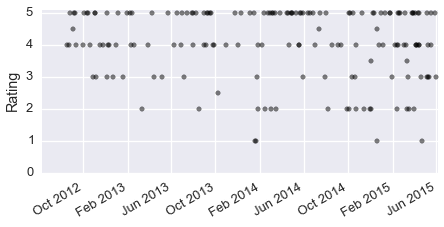

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(data.index, data['means'], color='k', alpha=0.5)
ax.set_ylim(0, 5.1)
ax.set_ylabel("Rating")
ax.set_xlim(xmax=date.today())
fig.autofmt_xdate()
fig.tight_layout(pad=0.1)

Now that we have ratings data, we need to find a way to calculate the average rating over time. A good way to do this is with a Gaussian process. 

Typically we want to infer some model parameters from our data. To do this with a Bayesian model, we define prior distributions over the model parameters, then calculate the posterior distributions of the parameters given the data and the data likelihood. However, we can instead avoid parameters by using a Gaussian process which is a ***distribution over functions***. That is, we can find a function that models our data by drawing from an infinite collection of functions without ever defining a functional form. Similar to the normal distribution, parametrized by mean $\mu$ and covariance $\Sigma$ parameters,

$$
p(x) \sim N(\mu, \Sigma),
$$

a Gaussian process is parametrized by mean and covariance *functions*

$$
p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime})).
$$

Typically we don't care about the mean function ($m(x) = 0$) and most of the business happens in the covariance function, often a squared exponential

$$
k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
$$

but it can be expanded with additional terms for linear effects, or effects on different scales, etc. 

To demonstrate the power of Gaussian process, I'll generate some synthetic data $y = f(x)$ with noise and use a Gaussian process to infer the true $f(x)$.


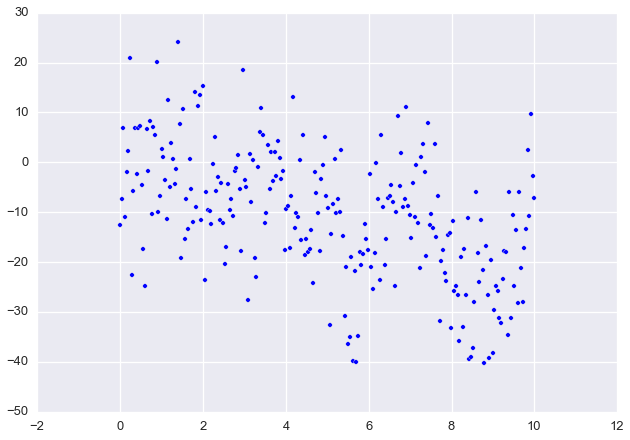

In [20]:
x = np.linspace(0, 10, 250)
y_true = -2*x + x*np.sin(2*x)
y = y_true + 10*np.random.randn(x.size)
plt.scatter(x, y)

A robust implentation can be found in [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html). The defaults are a constant mean function and the double exponential covariance function. The parameter `theta0` controls the length scale of the double exponential, while `nugget` is used for regularization, smoothing the prediction.

In [21]:
from sklearn import gaussian_process

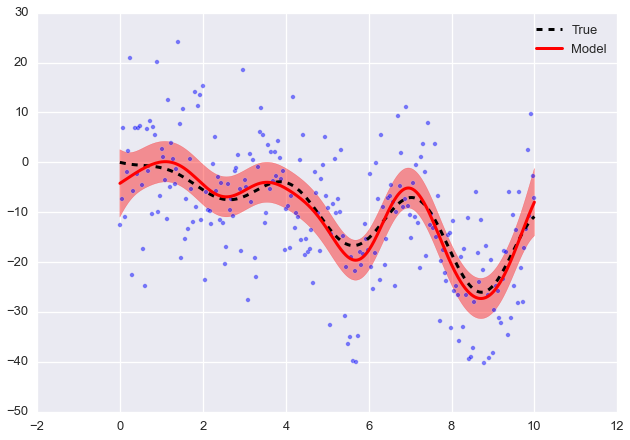

In [22]:
gp = gaussian_process.GaussianProcess(thetaL=1e-4, theta0=0.1, thetaU=1e3, nugget=1)
gp.fit(x[:,None], y)
x_hat = np.linspace(0, 10, 500)
y_hat, MSE = gp.predict(x_hat[:, None], eval_MSE=True)
sigma = np.sqrt(MSE)

plt.plot(x, y_true, '--k', lw=3, label="True")
plt.plot(x_hat, y_hat, '-r', lw=3, label="Model")
# 95% Confidence interval
plt.fill_between(x_hat, y_hat - 1.96*sigma, y_hat + 1.96*sigma, 
                 color='r', alpha=0.4, label="95%")
plt.scatter(x, y, alpha=0.5)

plt.legend(loc='upper right')

As you can see, we can recover the true function from the noisy data. We can use this to interpolate the rating of a business over time from user reviews. First, lets scrape the ratings data for each of the businesses we searched up earlier. Then, we can predict the user rating over time. 

In [23]:
ratings = {biz['name']: scrape_data(biz) for biz in bizs}

In [176]:
def rating_prediction(data, **gp_kwargs):
    # Add a column with the number of days since the earliest date 
    data = data.assign(days=lambda row: (row.index - data.index[0]).days)
    
    params = {'theta0': 0.1,
              'nugget': 0.01}
    params.update(**gp_kwargs)
    gp = gaussian_process.GaussianProcess(**params)
    gp.fit(data.days.values[:,None], data.means)
    
    # Predict the rating for all days 
    xs = np.arange(data.days[0], data.days[-1])[:,None]
    dates = [data.index[0] + td(days=i) for i in range((data.index[-1] - data.index[0]).days)]
    gp_predict = pd.Series(gp.predict(xs), index=dates)
    
    return gp_predict

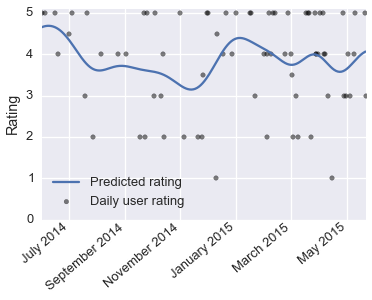

In [177]:
fig, ax = plt.subplots(figsize=(5,4))
# Grab ratings from the last year
data = ratings[bizs[1]['name']].ix[pd.to_datetime(date.today() - td(days=365)):]
prediction = rating_prediction(data, theta0=10, nugget=1)

ax.scatter(data.index, data.means, color='k', alpha=0.5, label='Daily user rating')
ax.plot(prediction.index, prediction.values, label='Predicted rating')
ax.set_xlim(prediction.index.min(), prediction.index.max())
ax.set_ylim(0,5.1)
ax.set_xticks(prediction.index[30::60])
ax.set_xticklabels([d.strftime("%B %Y") for d in prediction.index[30::60]],
                    rotation=40, ha='right')
ax.set_ylabel("Rating")
ax.legend(loc='lower left')
fig.tight_layout(pad=0.1)

Now we can predict the rating over time for a bunch of businesses at once. This is similar to [sparklines](http://en.wikipedia.org/wiki/Sparkline) in that we are seeing much more information compressed into a small area of screen space.

In [184]:
rating_predictions = []
for each in ratings.itervalues():
    # Choose date range here, for instance, from the last year
    data = each.ix[pd.to_datetime(date.today() - td(days=365)):]
    prediction = rating_prediction(data, theta0=10, nugget=1)
    rating_predictions.append(prediction)

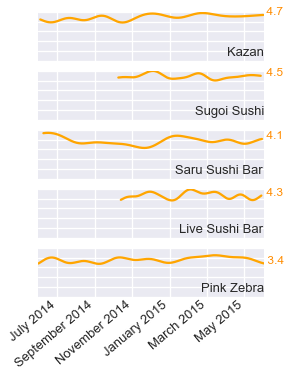

In [189]:
plt.rcParams['xtick.major.pad']='2'
fig, axes = plt.subplots(nrows=len(rating_predictions), sharex=True, figsize=(4,5))
for each, ax, biz in zip(rating_predictions, axes, bizs):
    ax.plot(each.index, each.values, color='orange')
    ax.set_ylim(0, 5.)
    x_min, x_max = ax.get_xlim()
    ax.text(x_max, 0.5, biz['name'], fontsize=13, ha='right')
    ax.text(x_max, each.values[-1], ' {:.1f}'.format(each.values[-1]),
            color='darkorange', fontsize=12)
    ax.set_yticklabels(['', '', '', '', '', ''])
axes[-1].set_xticks(each.index[30::60])
axes[-1].set_xticklabels([d.strftime("%B %Y") for d in each.index[30::60]],
                         rotation=40, ha='right')

fig.tight_layout(pad=0.1, h_pad=1, rect=(0, 0, 0.9, 1))